In [11]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from predcontrol_sf.control import User, Control
import predcontrol_sf.value_curves as vc
from predcontrol_sf.data_loader import load_data_bom_aus
from pathlib import Path
import datetime as dt


In [12]:
user1 = User(vc.value_curve_farmer_1, discharge_curve=vc.discharge_curve_farmer_1)
user2 = User(vc.value_curve_farmer_2)

In [13]:
ctrl = Control([user1, user2])

In [14]:
data_folder = Path(r"C:\Users\sgnodde\Documents\data\data_murray_boundary_bend")
bb_discharge = load_data_bom_aus(data_folder / 'bb_discharge.csv')
level = load_data_bom_aus(data_folder / 'bb_level.csv')

In [15]:
riverdata = pd.DataFrame({'level':level['Value'], 'discharge':bb_discharge['Value']}, index = level.index)
riverdata = riverdata.loc['2011': ]
riverdata['disch_farmer_2'] = np.NaN
riverdata['wl_farmer_1'] = np.NaN
riverdata['value'] = 0
riverdata

,level,discharge,disch_farmer_2,wl_farmer_1,value
date,,,,,
2011-01-01 00:00:00+10:00,7.216,589.060,NaN,NaN,0
2011-01-01 00:15:00+10:00,7.227,591.173,NaN,NaN,0
2011-01-01 00:30:00+10:00,7.218,589.444,NaN,NaN,0
2011-01-01 00:45:00+10:00,7.224,590.596,NaN,NaN,0
2011-01-01 01:00:00+10:00,7.213,588.485,NaN,NaN,0
...,...,...,...,...,...
2022-01-17 09:15:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:30:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:45:00+10:00,3.717,217.735,NaN,NaN,0


In [16]:
days_setting = 14
newsettingdates = [riverdata.index[4*24*days_setting]+days_setting*dt.timedelta(days=1)*i for i in range(11*int(365/days_setting))]

In [17]:
for newsettingdate in newsettingdates:
    level_weir = np.random.uniform(0,4)
    discharge = np.random.uniform(0,30)
    riverdata.loc[newsettingdate, 'wl_farmer_1'] = level_weir
    riverdata.loc[newsettingdate,'disch_farmer_2'] = discharge
riverdata

,level,discharge,disch_farmer_2,wl_farmer_1,value
date,,,,,
2011-01-01 00:00:00+10:00,7.216,589.060,NaN,NaN,0
2011-01-01 00:15:00+10:00,7.227,591.173,NaN,NaN,0
2011-01-01 00:30:00+10:00,7.218,589.444,NaN,NaN,0
2011-01-01 00:45:00+10:00,7.224,590.596,NaN,NaN,0
2011-01-01 01:00:00+10:00,7.213,588.485,NaN,NaN,0
...,...,...,...,...,...
2022-01-17 09:15:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:30:00+10:00,3.718,217.813,NaN,NaN,0
2022-01-17 09:45:00+10:00,3.717,217.735,NaN,NaN,0


<AxesSubplot:xlabel='date'>

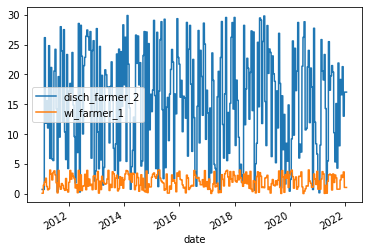

In [18]:
riverdata[['disch_farmer_2','wl_farmer_1']] = riverdata[['disch_farmer_2','wl_farmer_1']].ffill()
riverdata[['disch_farmer_2','wl_farmer_1']].plot()

In [19]:
import neat

In [20]:
generation = 0

In [21]:
config_path = "config_expl.txt"
config = neat.config.Config(neat.DefaultGenome,
                            neat.DefaultReproduction,
                            neat.DefaultSpeciesSet,
                            neat.DefaultStagnation,
                            config_path)

In [22]:
config

In [26]:
i = 0
enum_nsd = iter(newsettingdates)
while i < 10:
    newsettingdate = next(enum_nsd)
    print(newsettingdate)
    i+=1

2011-01-14 23:30:00+10:00
2011-01-28 23:30:00+10:00
2011-02-11 23:30:00+10:00
2011-02-25 23:30:00+10:00
2011-03-11 23:30:00+10:00
2011-03-25 23:30:00+10:00
2011-04-08 23:30:00+10:00
2011-04-22 23:30:00+10:00
2011-05-06 23:30:00+10:00
2011-05-20 23:30:00+10:00


In [ ]:
# inputs = water level, discharge now (will be more)

In [9]:
def run_control(genomes, config):
    # Init NEAT
    nets = []
    controls = []

    for id, g in genomes:
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        g.fitness = 0

        # Init my cars
        controls.append(Control())


    # Main loop
    global generation
    generation += 1

    enum_nsd = iter(newsettingdates)
    ind = next(enum_nsd)

    while True:
        
        # Input my data and get result from network
        dis = riverdata['discharge'][ind]
        lev = riverdata['level'][ind]

        for i, control in enumerate(controls):
            output = nets[i].activate([dis, lev])
            
            print(output) # output min/max ?

            ind = next(enum_nsd)
            genomes[i][1].fitness += control.return_total_value()

        break

In [8]:
p = neat.Population(config)

# Add reporter for fancy statistical result
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

# Run NEAT
p.run(run_control, 1000)

NameError: name 'run_control' is not defined